In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse.csgraph import reverse_cuthill_mckee

from matplotlib import pyplot as plt

In [2]:
class Mesh:
    def __init__(self):
        self.nodes_dict = {}   # Nodes dict <---> ID: [x y z]
        self.elems_dict = {}   # Elems dict <---> ID: [ne_1, ne_2, ...]
        self.N_nodes = 0
        self.N_elems = 0
        
    def read_mesh(self, mesh_name):
        # Reading nodes
        nodes_file = open(mesh_name + '_nodes.txt', 'r')
        
        for line in nodes_file:
            data_tokens = list(map(float, line.split(' ')))
            node_ID = int(data_tokens[0])
            coord_array = data_tokens[1:]
            self.nodes_dict[node_ID] = coord_array
            
        self.N_nodes = len(self.nodes_dict.keys())
        nodes_file.close()
        
        # Reading elems
        elems_file = open(mesh_name + '_elems.txt', 'r')
        
        for line in elems_file:
            if (line == ''):
                break
            data_tokens = list(map(int, line.replace(' \n', '').split(' ')))
            elem_ID = data_tokens[0]
            elem_nodes = data_tokens[1:]
            self.elems_dict[elem_ID] = elem_nodes
            
        self.N_elems = len(self.elems_dict.keys())
        elems_file.close()
        
        print(f'Mesh from [{mesh_name}] loaded.\n')
        print(f'Nodes: \t\t{self.N_nodes}')
        print(f'Elements: \t{self.N_elems}')
    
    def get_mesh(self):
        return self.nodes_dict, self.elems_dict

In [10]:
class FEM_matricies:
    def __init__(self, nodes_dict, elems_dict, nu, E):
        self.nodes_dict = nodes_dict                    # Nodes dict <---> ID: [x y z]
        self.elems_dict = elems_dict                    # Elems dict <---> ID: [ne_1, ne_2, ...]
        
        self.N_nodes = len(nodes_dict.keys())
        self.N_elems = len(elems_dict.keys())
        
        self.N_dofs = self.N_nodes * 2                  # 2D case, DOFs along X and Y
        self.dofs_mapping = {}                          # Degrees of freedom for each element
        
        self.nu = nu
        self.E = E
        
        # Triangle local stiffness matrix:
        self.local_K = np.array([
            [(3-4*nu)/(2-4*nu), 1/(2-4*nu), (1-nu)/(-1+2*nu), -0.5, -0.5, nu/(-1+2*nu)],
            [1/(2-4*nu), (3-4*nu)/(2-4*nu), nu/(-1+2*nu), -0.5, -0.5, (1-nu)/(-1+2*nu)],
            [(1-nu)/(-1+2*nu), nu/(-1+2*nu), (1-nu)/(1 - 2*nu), 0, 0, nu/(1-2*nu)],
            [-0.5, -0.5, 0, 0.5, 0.5, 0],
            [-0.5, -0.5, 0, 0.5, 0.5, 0],
            [nu/(-1+2*nu), (1-nu)/(-1+2*nu), nu/(1-2*nu), 0, 0, (1-nu)/(1-2*nu)]
        ]) / 2*(1+nu)
        
    # For each element, calculates its nodes DOFs    
    def map_dofs(self):
        for elem in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem]
            dofs = []
            for node in nodes:
                dofs.append(2*(node-1))       # DOF along X
                dofs.append(2*(node-1) + 1)   # DOF along Y
            self.dofs_mapping[elem] = dofs
    
    # For triangular mesh
    def assemble_stiffness_matrix(self):
        global_iK = np.zeros(36 * self.N_elems)
        global_jK = np.zeros(36 * self.N_elems)
        global_aK = np.zeros(36 * self.N_elems)
        
        for ei, elem in enumerate(list(self.elems_dict.keys())):
            iK = np.kron(self.dofs_mapping[elem], np.ones(6))
            jK = np.reshape(np.kron(self.dofs_mapping[elem], np.reshape(np.ones(6), (6,1))), -1)
            aK = np.reshape(self.local_K, -1)
            
            global_iK[36*ei : 36*(ei+1)] = iK
            global_jK[36*ei : 36*(ei+1)] = jK
            global_aK[36*ei : 36*(ei+1)] = aK
            
        self.stiffness_matrix = sparse.coo_matrix((global_aK,(global_iK, global_jK)),shape = (self.N_dofs, self.N_dofs)).tocsr()
        
    def build_incidence_matrix(self):
        self.incidence_matrix = np.zeros((self.N_nodes, self.N_nodes))
        
        # Calculating incidence from elements
        for elem_ID in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem_ID]
            for i in range(len(nodes)):
                self.incidence_matrix[nodes[i]-1][nodes[i-1]-1] = 1                # Marking LEFT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[(i+1)%len(nodes)]-1] = 1   # Marking RIGHT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[i]-1] = 1                  # Marking node itself
                
    def renumbering(self):
        graph = sparse.csr_matrix(self.incidence_matrix)                     # Creating input graph in scipy sparse matrix form
        permutation = reverse_cuthill_mckee(graph, symmetric_mode = False)   # Incidence matrix is guaranteed to be symmetric
        
        # Updating incidence matrix
        self.incidence_matrix = self.incidence_matrix[permutation, :][:, permutation]
        self.renum_perm = permutation
        
    def revert_renumbering(self):
        inverse_perm = np.argsort(self.renum_perm)
        
        self.incidence_matrix = self.incidence_matrix[inverse_perm, :][:, inverse_perm]
                
    def draw_incidence_matrix(self):
        plt.figure(figsize=(7, 7))
        plt.imshow(self.incidence_matrix, cmap = 'magma', interpolation = 'gaussian')
        
    def draw_stiffness_matrix(self):
        if (self.N_dofs > 1000):
            print("Too much DOFs: cannot visualize stiffness matrix")
            return
        
        plt.figure(figsize=(7, 7))
        np_represent = self.stiffness_matrix.toarray()
        for i in range(np_represent.shape[0]):
            for j in range(np_represent.shape[0]):
                if (np_represent[i][j] != 0):
                    np_represent[i][j] = 1.0
                    
        plt.imshow(np_represent, cmap = 'hot')
        
    def get_incidence_matrix(self):
        return self.incidence_matrix

In [11]:
mesh = Mesh()
mesh.read_mesh('Mesh_1')

mesh_nodes, mesh_elems = mesh.get_mesh()

Mesh from [Mesh_1] loaded.

Nodes: 		221
Elements: 	364


In [12]:
f_matr = FEM_matricies(mesh_nodes, mesh_elems, 0.3, 1)
f_matr.build_incidence_matrix()

Incidence matrix before renumbering:


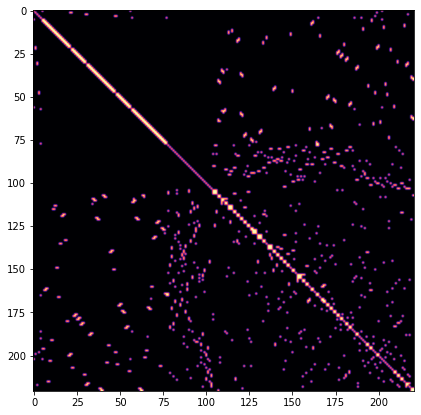

In [13]:
print('Incidence matrix before renumbering:')
f_matr.draw_incidence_matrix()

In [14]:
f_matr.renumbering()

Incidence matrix after renumbering: 


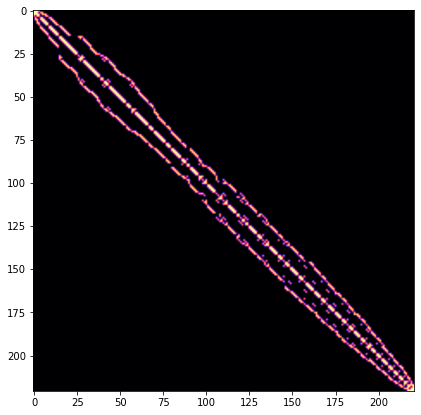

In [15]:
print('Incidence matrix after renumbering: ')
f_matr.draw_incidence_matrix()

In [16]:
f_matr.revert_renumbering()

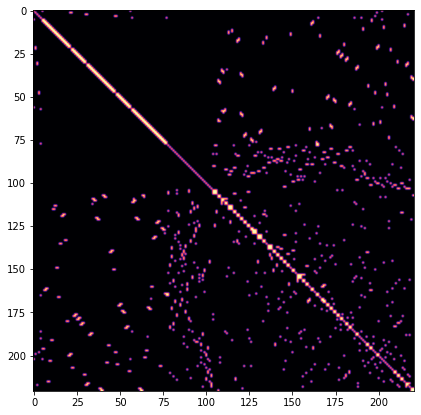

In [17]:
f_matr.draw_incidence_matrix()